In [1]:
## CONTENTS

# (1) scatter/heat map for variables by pan-dataset values
# (2) What's the balance between for/against Single Market?
# (3) Is there a pronounced ethnic (White British/Not) split on Brexit(happyEULeave)?
# (4) likeCorbyn by average static values over time
# (5) Covariation in al lr scales variables which creates the weird distributions
# (6) Who are the centrists?
# (7) Relative political positioning by *where you place parties*
# (8) Overlap between likeMay/happyTrump

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [3]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

BES_R_data_files = BES_data_folder + "R_data" + os.sep
if not os.path.exists( BES_R_data_files ):
    os.makedirs( BES_R_data_files )


In [4]:
dataset_name = "W13_comb"

In [5]:
%%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

# BES_Panel = pd.read_stata( data_subfolder + dataset_filename )
BES_Panel  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
print("BES_Panel", BES_Panel.shape )

BES_Panel (68625, 5150)
Wall time: 3.53 s


In [6]:
%%time

BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
print("BES_numeric",  BES_numeric.shape )

var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

BES_numeric (68625, 4969)
var_type (5150, 13)
BES_non_numeric (68625, 126)
BES_reduced (68625, 2572)
BES_reduced_with_na (68625, 2572)
Wall time: 21.5 s


In [6]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde

In [12]:
## test different options for saving BES_Panel (without transforming into numerical only!)

# options:
# cPickle-protocol2
# msgpack - A binary JSON alternative
# feather
#      'cPickle-p2': [cPickle.loads, partial(cPickle.dumps, protocol=2)],
#      'msgpack': [pd.read_msgpack, pd.Series.to_msgpack],

import pickle # no cPickle in python 3 - it's implicit


In [21]:
%%time
filename = BES_data_folder + dataset_name + os.sep + dataset_name + '.msgpack'
BES_Panel2  = pd.read_msgpack(filename)
BES_Panel2.equals(BES_Panel)

#4s and it worked just fine
## and it reduces the size!
## feels like using hdf was a *monumental* fuck up (/extremely inappropriate for the file size/access profile)

Wall time: 3.98 s


In [9]:
for dataset_name in BES_file_manifest["Name"]:
    if dataset_name == "W13_comb":
        continue
    manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

    data_subfolder = BES_data_folder + dataset_name + os.sep

    dataset_filename = manifest["Stata_Filename"].values[0]
    
    BES_Panel = pd.read_stata( data_subfolder + dataset_filename )
    filename = BES_data_folder + dataset_name + os.sep + dataset_filename.replace('.dta','.msgpack')
    BES_Panel.to_msgpack(filename)

    
    #BES_Panel  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))    


In [12]:
import os
data_subfolder = BES_data_folder + dataset_name + os.sep
file_list = os.listdir(data_subfolder)
for file in file_list:
    if ".hdf" in file and file.replace('.hdf', '.msgpack') not in file_list:
        print(file)
        temp = pd.read_hdf(data_subfolder+file)
        temp_filename = file.replace('.hdf','.msgpack')
        temp.to_msgpack(data_subfolder+temp_filename)
        

In [ ]:
# (1) scatter/heat map for variables by pan-dataset values ####

# Initial motivation: Where does Corbyn's appeal to the Left outweigh his repulsion to Authoritarians?
# output: likeCorbyn_byvalues_overtime

In [7]:
pan_dataset_values = pd.read_csv( BES_small_data_files + "pan_dataset_values.csv", encoding=encoding)

In [8]:
# recreate granularity at whatever level

granularity = 40
pan_dataset_values["lr_uniform"] = pd.qcut( pan_dataset_values["raw_gen_lr_vals"], q=granularity, labels=range(0,granularity))
pan_dataset_values["al_uniform"] = pd.qcut( pan_dataset_values["raw_gen_al_vals"], q=granularity, labels=range(0,granularity))

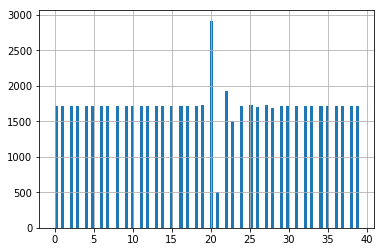

In [9]:
# check granularity
pan_dataset_values["al_uniform"].hist(bins=100)

In [ ]:
# look at interesting like variables
[(x,BES_Panel[x].notnull().sum()) for x in sorted(BES_Panel.columns) if "like" in x]

In [ ]:
(like_var, like_name) = ("likeMay", "Theresa May")
(like_var, like_name) = ("likeBNP", "British National Party")
(like_var, like_name) = ("likeBennett", "Natalie Bennett")
(like_var, like_name) = ("likeBlair", "Tony Blair")
(like_var, like_name) = ("likeBoris", "Boris Johnson")
(like_var, like_name) = ("likeCameron", "David Cameron")
(like_var, like_name) = ("likeClegg", "Nick Clegg")
(like_var, like_name) = ("likeCon", "The Conservative Party")
(like_var, like_name) = ("likeDavis", "David Davis")
(like_var, like_name) = ("likeFarage", "Nigel Farage")
(like_var, like_name) = ("likeFarron", "Tim Farron")
(like_var, like_name) = ("likeJarvis", "Dan Jarvis")
(like_var, like_name) = ("likeLD", "The Liberal Democrats")
(like_var, like_name) = ("likeLab", "The Labour Party")
(like_var, like_name) = ("likeLucas", "Caroline Lucas")
(like_var, like_name) = ("likeMcDonnell", "John McDonnell")
(like_var, like_name) = ("likeMiliband", "Ed Miliband")
(like_var, like_name) = ("likeNuttall", "Paul Nuttall")
(like_var, like_name) = ("likeOsborne", "George Osborne")
# (like_var, like_name) = ("likePC", "Plaid Cymru")
(like_var, like_name) = ("likeRudd", "Amber Rudd")
(like_var, like_name) = ("likeSEvans", "Suzanne Evans")
(like_var, like_name) = ("likeSNP", "The Scottish Nationalist Party")
# (like_var, like_name) = ("likeSalmond", "Alex Salmond")
(like_var, like_name) = ("likeSturgeon", "Nicola Sturgeon")
(like_var, like_name) = ("likeUKIP", "The UK Independence Party")
(like_var, like_name) = ("likeWatson", "Tom Watson")
(like_var, like_name) = ("likeWood", "Leanne Wood")
#
(like_var, like_name) = ("euPriorityBalance", "euPriorityBalance")
(like_var, like_name) = ("immigSelf", "immigSelf")
(like_var, like_name) = ("likeCorbyn", "Jeremy Corbyn")
(like_var, like_name) = ("likeMay", "Theresa May")

x_axis = "al_uniform"
y_axis = "lr_uniform"


mean_like_Corbyn = BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
.replace("Don't know",np.nan).apply(lambda x:x.cat.codes).replace(-1,np.nan).mean(axis=1)
mask = mean_like_Corbyn.notnull()

likeCorbyn_heatmap = pd.crosstab(index = pan_dataset_values[y_axis][mask],
            columns = pan_dataset_values[x_axis][mask],
            values = mean_like_Corbyn[mask],
            aggfunc = np.mean)

plt.figure(figsize = (16,10))
ax = sns.heatmap(data = likeCorbyn_heatmap.replace(np.nan,-1),
            cbar_kws={'label': like_var+ ' 0-Strongly dislike, 10-Strongly like'})
ax.invert_yaxis()
# plt.colorbar(points);
plt.xlabel("libertarian-authoritarian (flattened)");
plt.ylabel("economic_right-economic_left (flattened)");
plt.title("How much do you like or dislike "+like_name+"?\n(mean value, -1 = no data))\n(N = "+str(mask.sum())+")")
plt.savefig(BES_output_folder + "likeCorbyn_byvalues_overtime" + os.sep + like_var +"_by_allr_heatmap" + ".png")

mean_like_Corbyn = BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
.replace("Don't know",np.nan).apply(lambda x:x.cat.codes).replace(-1,np.nan).mean(axis=1)
mask = mean_like_Corbyn.notnull()

x_axis = "xt_std_al"
y_axis = "xt_std_lr"

corbynLike_by_values = pan_dataset_values[[y_axis,x_axis]][mask]
corbynLike_by_values[like_var] = mean_like_Corbyn[mask]

plt.figure(figsize = (16,10))
points = plt.scatter(data = corbynLike_by_values, x = x_axis, y = y_axis, c = like_var,
                     cmap="brg", alpha=.5, s=10)
cbar = plt.colorbar(points);
cbar.set_label(like_var+' 0-Strongly dislike, 10-Strongly like', rotation=270)
plt.xlabel("libertarian-authoritarian (normalised)");
plt.ylabel("economic_right-economic_left (normalised)");
plt.title("How much do you like or dislike "+like_name+"?\n(N = "+str(mask.sum())+")")
plt.savefig(BES_output_folder + "likeCorbyn_byvalues_overtime" + os.sep + like_name+"_by_allr_scatter" + ".png") 

In [7]:
# (2) What's the balance between for/against Single Market?
# pretty much exactly 50:50 as of post GE2017

# output folder "randomFunPlots"

In [8]:
euprior = BES_Panel['euPriorityBalanceW13'].replace("Don't know", np.nan).cat.codes.replace(-1,np.nan)
mask = euprior.notnull()
weighted_mean = (euprior[mask] * BES_Panel['wt_new_W13'][mask]).mean()

NameError: name 'BES_Panel' is not defined

In [ ]:
euprior[mask].mean()

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(BES_Panel['euPriorityBalanceW13']);
plt.xticks(rotation=90);
plt.title("Brexit priority: access to single market versus controlling immigration?\n(BES Wave 13, N = "+str(mask.sum()) +")\nDemographically weighted mean (-DKs) = "+str(round(weighted_mean,2)));
dataset_citation = "Source: " + manifest["Citation"].values[0]
plt.annotate(dataset_citation, (0,0), (0, -165),
                             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7)  
plt.savefig(BES_output_folder + "randomFunPlots" + os.sep + "single_market_vs_controlling_immigration" + ".png",bbox_inches='tight')

In [ ]:
# (3) Is there a pronounced ethnic (White British/Not) split on Brexit(happyEULeave)?
# not really (general recollection: the driver isn't ethnicity but differences in values)
# coda: p_surridge says BES ethnic variable not very good

# output folder: "randomFunPlots"

In [ ]:
Leavers = BES_Panel["profile_eurefvote"] == "Leave the EU"
Remainers = BES_Panel["profile_eurefvote"] == "Stay/remain in the EU"

In [ ]:
OneDropWhiteBritish = (BES_Panel[[x for x in BES_Panel.columns if "ethnicity" in x]]=="White British").any(axis=1)
OneDropWhiteBritish = BES_Panel["profile_ethnicity"]=="White British"

In [ ]:
mask = (Remainers) & (OneDropWhiteBritish) & BES_Panel['happyEULeaveW13'].notnull()


plt.figure(figsize=(12,6))
plt.subplot(111)
sns.countplot(BES_Panel['happyEULeaveW13'][mask]);
plt.xticks(rotation=90);
plt.title("White British Remainers: How happy or how disappointed are you that the UK voted to leave the EU?\n(BES Wave 13, N = "+str(mask.sum()) +")");
dataset_citation = "Source: " + manifest["Citation"].values[0]
plt.annotate(dataset_citation, (0,0), (0, -165),
                             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7)  
plt.savefig(BES_output_folder + "randomFunPlots" + os.sep + "happyEULeave_Remainers_by_ethnicity_WB" + ".png",
            bbox_inches='tight')

In [ ]:
# (4) likeCorbyn by average static values over time
# also include White British & Not London subsample


# output folder: "likeCorbyn_byvalues_overtime"

In [ ]:
pan_dataset_values = pd.read_csv( BES_small_data_files + "pan_dataset_values.csv", encoding=encoding)

In [ ]:
likeCorbyn_panvalues_corr = pd.concat([ BES_reduced[[x for x in BES_reduced if re.match("likeCorbyn",x)]],
                                        pan_dataset_values[["xt_std_lr","xt_std_al"]]],axis=1).corr()

Corbyn_over_time = likeCorbyn_panvalues_corr[["xt_std_lr","xt_std_al"]].drop(["xt_std_lr","xt_std_al"])

Corbyn_over_time_sns = Corbyn_over_time.copy()
Corbyn_over_time_sns["xt_std_al"] = -Corbyn_over_time_sns["xt_std_al"]
Corbyn_over_time_sns = Corbyn_over_time_sns.stack().reset_index()
Corbyn_over_time_sns.columns = ["likeCorbyn", "value scale","correlation"]
Corbyn_over_time_sns["value scale"] = Corbyn_over_time_sns["value scale"].replace("xt_std_lr","economic(right_left)").replace("xt_std_al","social(conservative_liberal)")
Corbyn_over_time_sns["likeCorbyn"] = [re.search("(W\d+)",x).group(0) for x in Corbyn_over_time_sns["likeCorbyn"]]
g = sns.pointplot(data = Corbyn_over_time_sns, x = "likeCorbyn", hue = "value scale", y="correlation");
# plt.xticks(rotation=45);
plt.savefig(BES_output_folder +os.sep+ "likeCorbyn_byvalues_overtime" + os.sep + "likeCorbyn_byvalues_overtime" + ".png")

In [ ]:
values = ["xt_std_lr","xt_std_al","genImmigSentiment"]
likeCorbyn_panvalues_corr = pd.concat([ BES_reduced[[x for x in BES_reduced if re.match("likeCorbyn",x)]],
                                        pan_dataset_values[values]],axis=1).corr()

Corbyn_over_time = likeCorbyn_panvalues_corr[values].drop(values)

Corbyn_over_time_sns = Corbyn_over_time.copy()
Corbyn_over_time_sns["xt_std_al"] = -Corbyn_over_time_sns["xt_std_al"]
Corbyn_over_time_sns = Corbyn_over_time_sns.stack().reset_index()
Corbyn_over_time_sns.columns = ["likeCorbyn", "value scale","correlation"]
Corbyn_over_time_sns["value scale"] = Corbyn_over_time_sns["value scale"]\
    .replace("xt_std_lr","economic(right_left)")\
    .replace("xt_std_al","social(conservative_liberal)")\
    .replace("genImmigSentiment","immigration(negative_positive)")
Corbyn_over_time_sns["likeCorbyn"] = [re.search("(W\d+)",x).group(0) for x in Corbyn_over_time_sns["likeCorbyn"]]

wave_dates = BES_file_manifest[ BES_file_manifest["Only_or_Combined"] == "Only" ][["Wave No","Date_Start"]]
wave_dates["Wave No"] = wave_dates["Wave No"].apply(lambda x: "W"+str(x))
wave_dates = wave_dates.set_index("Wave No")
Corbyn_over_time_sns["likeCorbyn"] = Corbyn_over_time_sns["likeCorbyn"].apply(lambda x: wave_dates.loc[x].values[0])

plt.figure(figsize = (10,6))

g = sns.pointplot(data = Corbyn_over_time_sns, x = "likeCorbyn", hue = "value scale", y="correlation");
# plt.xticks(rotation=45);

# likeCorbyn_byvalues_overtime_includingImmig

plt.xlabel("Wave Date")
plt.title("How much do you like or dislike Jeremy Corbyn?")
plt.savefig(BES_output_folder +os.sep+ "likeCorbyn_byvalues_overtime" + os.sep + "likeCorbyn_byvalues_overtime_clearer" + ".png")


In [ ]:
pan_dataset_values["female"] = pd.get_dummies(pan_dataset_values["gender"], drop_first=True)["Female"]

In [ ]:
DefinitelyNotLondon = (BES_Panel["gor"]!="London") & (BES_Panel["gor"].notnull())
DefinitelyWhiteBritish = (BES_Panel["profile_ethnicity"]=="White British") & (BES_Panel["profile_ethnicity"].notnull())
mask = DefinitelyWhiteBritish & DefinitelyNotLondon

mask.sum()

In [ ]:
plt.figure(figsize = (10,6))

g = sns.pointplot(data = Corbyn_over_time_sns, x = "likeCorbyn", hue = "value scale", y="correlation");


values = ["xt_std_lr","xt_std_al","genImmigSentiment"]
likeCorbyn_panvalues_corr = pd.concat([ BES_reduced[[x for x in BES_reduced if re.match("likeCorbyn",x)]],
                                        pan_dataset_values[values]],axis=1)[mask].corr()

Corbyn_over_time = likeCorbyn_panvalues_corr[values].drop(values)

label = "(WB&NL)"

Corbyn_over_time_sns = Corbyn_over_time.copy()
Corbyn_over_time_sns["xt_std_al"] = -Corbyn_over_time_sns["xt_std_al"]
Corbyn_over_time_sns = Corbyn_over_time_sns.stack().reset_index()
Corbyn_over_time_sns.columns = ["likeCorbyn", "value scale","correlation"]
Corbyn_over_time_sns["value scale"] = Corbyn_over_time_sns["value scale"]\
    .replace("xt_std_lr","economic(right_left)"+label)\
    .replace("xt_std_al","social(conservative_liberal)"+label)\
    .replace("genImmigSentiment","immigration(negative_positive)"+label)
Corbyn_over_time_sns["likeCorbyn"] = [re.search("(W\d+)",x).group(0) for x in Corbyn_over_time_sns["likeCorbyn"]]

wave_dates = BES_file_manifest[ BES_file_manifest["Only_or_Combined"] == "Only" ][["Wave No","Date_Start"]]
wave_dates["Wave No"] = wave_dates["Wave No"].apply(lambda x: "W"+str(x))
wave_dates = wave_dates.set_index("Wave No")
Corbyn_over_time_sns["likeCorbyn"] = Corbyn_over_time_sns["likeCorbyn"].apply(lambda x: wave_dates.loc[x].values[0])
# Corbyn_over_time_sns["gender"] = BES_Panel["gender"]

# plt.figure(figsize = (10,6))

sns.pointplot(data = Corbyn_over_time_sns, x = "likeCorbyn", hue = "value scale", y="correlation", linestyles="--", markers = "v");
# plt.xticks(rotation=45);
# likeCorbyn_byvalues_overtime_includingImmig

plt.title("likeCorbyn_WhiteBritish_and_NotLondon (N = "+str(mask.sum()) +")");
plt.savefig(BES_output_folder +os.sep+ "likeCorbyn_byvalues_overtime" + os.sep + "likeCorbyn_WhiteBritish_and_NotLondon_comparable" + ".png");

In [ ]:
# (5) Covariation in al lr scales variables which creates the weird distributions

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
BES_vals[[x for x in BES_Panel.columns if re.match("(al|lr)\dW1W2W3W4W5",x)]].hist(ax=ax, bins=5);

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
al_lr_vals = [x for x in BES_Panel.columns if re.match("(al|lr)\dW13",x)]
BES_vals = BES_Panel[al_lr_vals]
BES_vals = BES_vals.replace("Don't know",np.nan).dropna().apply(lambda x: x.cat.codes)
BES_vals[al_lr_vals].hist(ax=ax, bins=5);

In [ ]:
lr_vals = [x for x in BES_Panel.columns if re.match("(lr)\dW13",x)]
lr_corr = pd.get_dummies(BES_Panel[lr_vals].replace("Don't know",np.nan).dropna()).corr()
lr_corr = lr_corr.drop([x for x in lr_corr.index if "Don't know" in x]).drop([x for x in lr_corr.columns if "Don't know" in x],axis=1)
lr_corr = lr_corr.where(np.triu(np.ones(lr_corr.shape), k=5).astype(np.bool))
lr_corr.stack().sort_values()

In [ ]:
lr_corr.stack().sort_values().head(10)

In [ ]:
lr_corr.stack().sort_values().tail(10)

In [ ]:
# (6) Who are the centrists?

In [ ]:
Centrist_corr = BES_reduced.corrwith( (BES_Panel[[x for x in BES_Panel if "leftRight" in x]]=="5").mean(axis=1) )
Centrist_corr.sort_values()

In [ ]:
everCentrist = np.any(BES_Panel[[x for x in BES_Panel if "leftRight" in x]]=="5",axis=1).astype('float')

In [ ]:
everCentrist_corr = BES_reduced.corrwith( pd.DataFrame(everCentrist)[0] )
everCentrist_corr.sort_values()

In [ ]:
everCentrist_corr.loc[[x for x in BES_reduced.columns if "lr_scale" in x]]

In [ ]:
everCentrist_corr.loc[[x for x in BES_reduced.columns if "al_scale" in x]]

In [ ]:
# (7) Relative political positioning by *where you place parties*

In [ ]:
all_placement = [x for x in BES_reduced if re.match("lr[^0-9_]+W\d+__Right"+\
                                    '|EUIntegration[^S]+W\d+__Protect our independence'\
                                    '|immig[^S]+W\d+__Allow many more'\
                                    '|tryReduceImmig\w+W\d+_Yes'\
                                    '|tryReduceInequality\w+W\d+_Yes'\
                                    '|certaintyEU\w+W\d+__Very certain'\
                                    '|conPartner\w+W\d+_Would join Conservatives'\
                                    '|labPartner\w+W\d+_Would join Labour'\
                                    '|noChanceCoalition\w+W\d+_Yes'\
                                    ,x)]

In [ ]:
## Factor Analysis by <other>placement

# sorted([x for x in BES_reduced if "UKIP" in x])
# Placement
# 'lrUKIPW2__Right'
# 'EUIntegrationUKIPW7__Protect our independence'
# 'immigUKIPW7__Allow many more'
# 'tryReduceImmigUKIPW4_Yes',
# 'tryReduceInequalityUKIPW4_Yes',
# 'certaintyEUUKIPW8__Very certain'
# 'conPartnerUKIPW4_Would join Conservatives'
# 'labPartnerUKIPW4_Would join Labour'
# 'noChanceCoalitionUKIPW11_Yes'

# Preference
# 'winConstituencyUKIPW4__100 - Very likely to win'
#'handleMIIUKIPW5__Very well'
#'likeUKIPW7__Strongly like'
#'ptvUKIPW7__Very likely'
#'achieveReduceImmigUKIPW11_Yes' ?
# 'ashcroftW4_United Kingdom Independence Party (UKIP)'
#'bestOnMIIW11_United Kingdom Independence Party (UKIP)'

#'generalElectionVoteW10_United Kingdom Independence Party (UKIP)'
# 'partyIdW10_United Kingdom Independence Party (UKIP)'
#'profile_past_vote_2005_United Kingdom Independence Party (UKIP)'

In [ ]:
 [x for x in BES_reduced if re.match("lr[^_]+W\d+(__Right|__Strongly agree)|leftRightW\d+__Right",x)]

In [ ]:
# lr placement inc self + lr values
lr_placement_inc_self_lr_vals = [x for x in BES_reduced if re.match("lr[^_]+W\d+(__Right|__Strongly agree)|leftRightW\d+__Right",x)]
BES = BES_reduced[lr_placement_inc_self_lr_vals]
Treatment = dataset_name + "lr_placement_inc_self_lr_Vals"

In [ ]:
# lr placement inc self
lr_placement_inc_self = [x for x in BES_reduced if re.match("lr[^0-9_]+W\d+__Right|leftRightW\d+__Right",x)]
BES = BES_reduced[lr_placement_inc_self]
Treatment = dataset_name + "lr_placement_inc_self"

In [ ]:
BES = BES_reduced[lr_placement]
Treatment = dataset_name + "lr_placement"

In [ ]:
#all_placement
BES = BES_reduced[all_placement]
Treatment = dataset_name + "all_placement"
# confusing!

In [ ]:
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

# normalise data (subtract out the mean, divide through by standard deviation)

clean_feature_set_std = StandardScaler().fit_transform(BES.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES.columns,
                             index   = BES.index      )
    

n_components = BES_std.shape[1]
# n_components = 3
decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_std.index)
                             

load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 
    
    
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_std.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 5, show_histogram = False)

In [ ]:
from sklearn import cluster
X = X_r

two_means = cluster.MiniBatchKMeans(n_clusters=7)
two_means.fit(X)

labels = two_means.labels_
cluster_centers = two_means.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

In [ ]:
x_axis = 0
y_axis = 1

xlim = np.floor( BES_decomp.loc[ :, x_axis ].min() ), np.ceil( BES_decomp.loc[ :, x_axis ].max() )
ylim = np.floor( BES_decomp.loc[ :, y_axis ].min() ), np.ceil( BES_decomp.loc[ :, y_axis ].max() )

fig = plt.figure( figsize=(16,10) )
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, x_axis], X[my_members, y_axis], col + '.', alpha=.5)
    plt.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Estimated number of clusters: %d' % n_clusters_);

In [ ]:
x_axis = 0
y_axis = 2


fig = plt.figure( figsize=(16,10) )
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, x_axis], X[my_members, y_axis], col + '.', alpha=.5)
    plt.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Estimated number of clusters: %d' % n_clusters_);

In [ ]:
%%time
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
# from sklearn.datasets.samples_generator import make_blobs

X = X_r

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.5, n_samples=1000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
# ms = MeanShift()
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


fig = plt.figure( figsize=(16,10) )
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, x_axis], X[my_members, y_axis], col + '.')
    plt.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

fig.savefig(output_subfolder + decomp_method+ os.sep +"Cluster_estimation.png",bbox_inches='tight')


In [ ]:
# (8) Overlap between likeMay/happyTrump

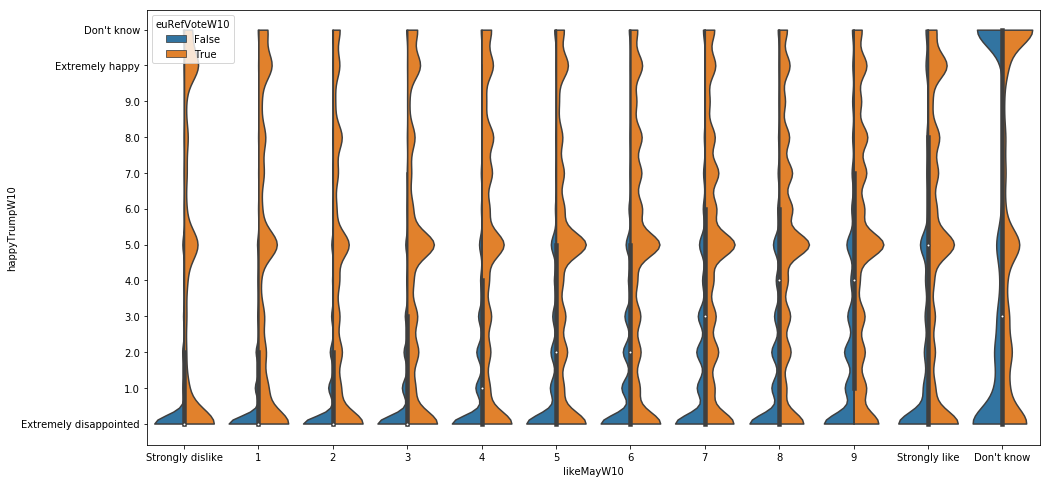

In [47]:

fig = plt.figure(figsize = (16,8))
ax = plt.gca()
sns.violinplot(ax=ax, y= BES_Panel['happyTrumpW10'].cat.codes, x= BES_Panel['likeMayW10'],
               hue = BES_Panel['euRefVoteW10']=="Leave the EU", split=True, cut=0, scale='width', bw=.1)
ax.set_ylabel('happyTrumpW10')
plt.yticks(range(0,len(BES_Panel['happyTrumpW10'].cat.categories)), BES_Panel['happyTrumpW10'].cat.categories )
plt.savefig(BES_output_folder + "randomFunPlots" + os.sep + "Trump_May_OverlapW10" + ".png",bbox_inches='tight')

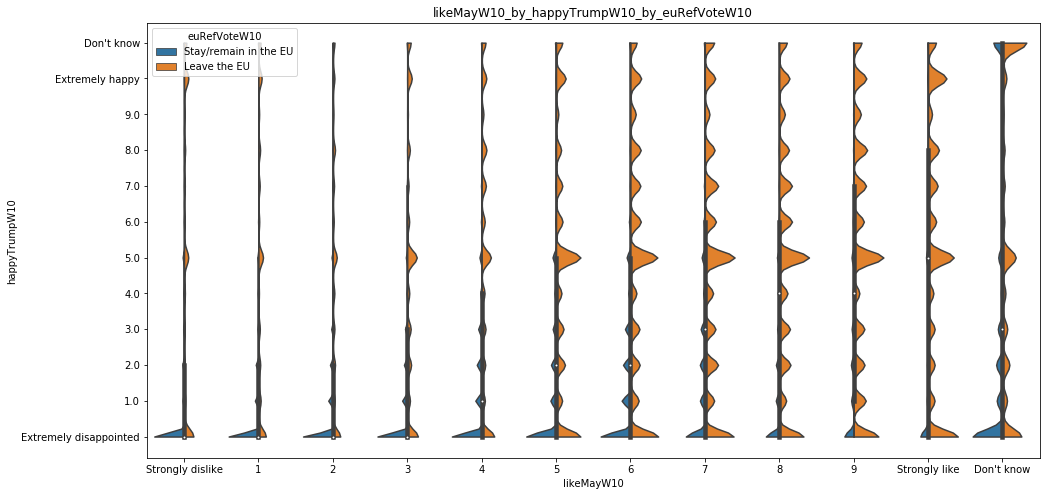

In [73]:
fig = plt.figure(figsize = (16,8))
ax = plt.gca()
x = 'likeMayW10'
y = 'happyTrumpW10'
hue = 'euRefVoteW10'
sns.violinplot(ax=ax, y= BES_Panel[y].cat.codes, x= BES_Panel[x],
               hue = BES_Panel[hue].cat.set_categories(BES_Panel[hue].cat.categories[0:2]),
               split=True, cut=0, scale='count', bw=.05)
ax.set_ylabel(y)
plt.yticks(range(0,len(BES_Panel[y].cat.categories)), BES_Panel[y].cat.categories )
title = x +"_by_" + y +"_by_" + hue
plt.title(title)
plt.savefig(BES_output_folder + "randomFunPlots" + os.sep + title + ".png",bbox_inches='tight')

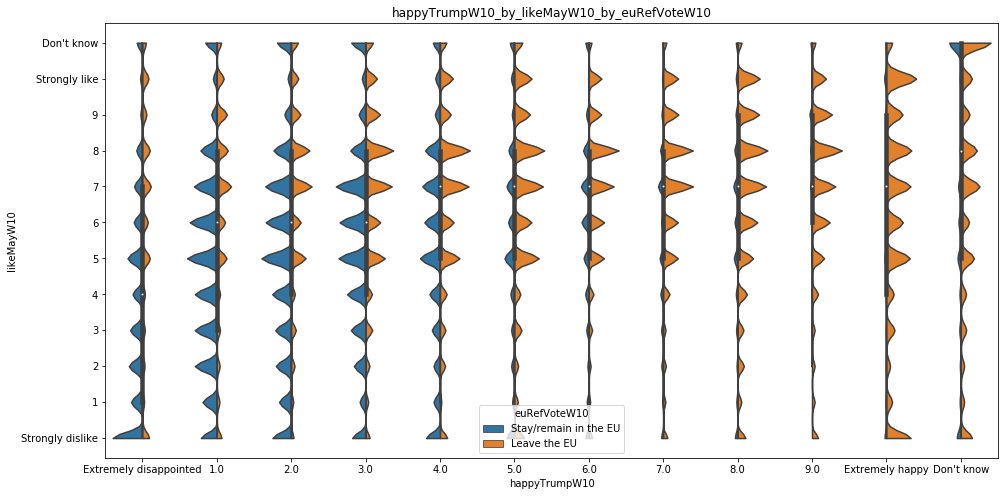

In [74]:
fig = plt.figure(figsize = (16,8))
ax = plt.gca()
y = 'likeMayW10'
x = 'happyTrumpW10'
hue = 'euRefVoteW10'
sns.violinplot(ax=ax, y= BES_Panel[y].cat.codes, x= BES_Panel[x],
               hue = BES_Panel[hue].cat.set_categories(BES_Panel[hue].cat.categories[0:2]),
               split=True, cut=0, scale='count', bw=.05)
ax.set_ylabel(y)
plt.yticks(range(0,len(BES_Panel[y].cat.categories)), BES_Panel[y].cat.categories )
title = x +"_by_" + y +"_by_" + hue
plt.title(title)
plt.savefig(BES_output_folder + "randomFunPlots" + os.sep + title + ".png",bbox_inches='tight')

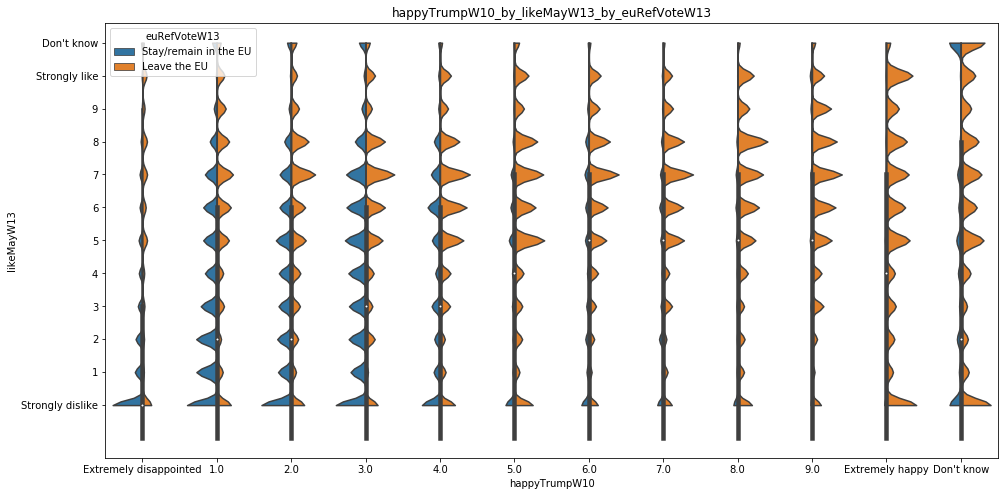

In [75]:
fig = plt.figure(figsize = (16,8))
ax = plt.gca()
y = 'likeMayW13'
x = 'happyTrumpW10'
hue = 'euRefVoteW13'
sns.violinplot(ax=ax, y= BES_Panel[y].cat.codes, x= BES_Panel[x],
               hue = BES_Panel[hue].cat.set_categories(BES_Panel[hue].cat.categories[0:2]),
               split=True, cut=0, scale='count', bw=.05)
ax.set_ylabel(y)
plt.yticks(range(0,len(BES_Panel[y].cat.categories)), BES_Panel[y].cat.categories )
title = x +"_by_" + y +"_by_" + hue
plt.title(title)
plt.savefig(BES_output_folder + "randomFunPlots" + os.sep + title + ".png",bbox_inches='tight')

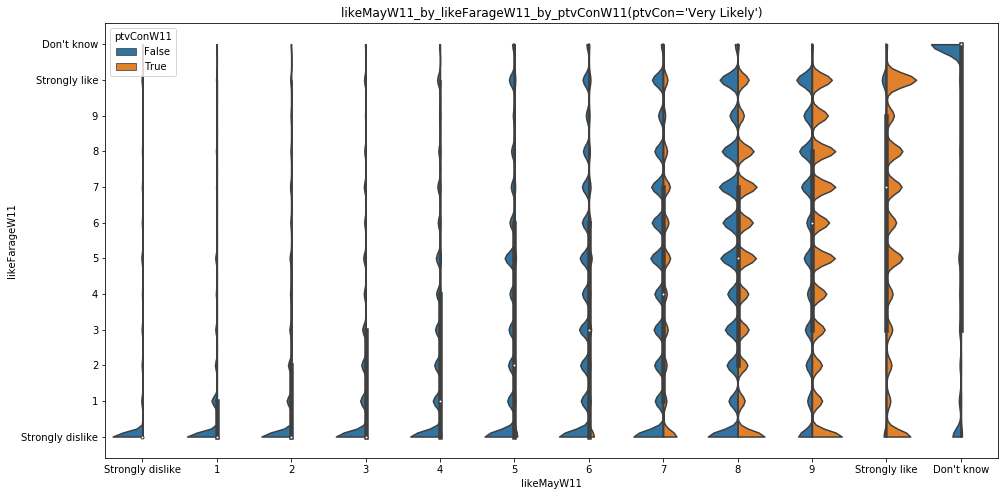

In [112]:
fig = plt.figure(figsize = (16,8))
ax = plt.gca()
x = 'likeMayW11'
y = 'likeFarageW11'
hue = 'ptvConW11'
sns.violinplot(ax=ax, y= BES_Panel[y].cat.codes, x= BES_Panel[x],
               hue = BES_Panel[hue]=="Very likely",
               split=True, cut=0, scale='count', bw=.05)
ax.set_ylabel(y)
plt.yticks(range(0,len(BES_Panel[y].cat.categories)), BES_Panel[y].cat.categories )
title = x +"_by_" + y +"_by_" + hue + "(ptvCon='Very Likely')"
plt.title(title)
plt.savefig(BES_output_folder + "randomFunPlots" + os.sep + title + ".png",bbox_inches='tight')

In [107]:
[x for x in BES_Panel.columns if "likeFarage" in x]

['likeFarageW1',
 'likeFarageW2',
 'likeFarageW3',
 'likeFarageW4',
 'likeFarageW5',
 'likeFarageW6',
 'likeFarageW7',
 'likeFarageW8',
 'likeFarageW9',
 'likeFarageW10',
 'likeFarageW11']

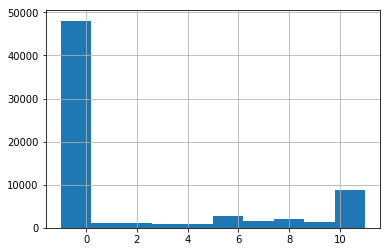

In [94]:
BES_Panel['ptvConW10'].cat.codes.hist()

In [89]:
BES_Panel['ptvConW10'].value_counts()

Very unlikely    9761
Very likely      5449
Don't know       3341
8                1945
7                1687
5                1622
9                1289
6                1158
2                1150
1                1113
3                 998
4                 806
Name: ptvConW10, dtype: int64

In [100]:
[x for x in BES_reduced.columns if "happyTrump" in x]

['happyTrumpW10__Extremely happy']

In [106]:
# corrs = BES_reduced.corrwith(BES_reduced['happyTrumpW10__Extremely happy'])

In [102]:
mask = BES_reduced['happyTrumpW10__Extremely happy'].notnull()
corrs = BES_reduced[mask].corrwith(BES_reduced['happyTrumpW10__Extremely happy'][mask])

In [105]:
corrs.sort_values()

generalElectionVoteW10_Labour                                     -0.379625
immigCulturalW10__Enriches cultural life                          -0.379128
partyIdW10_Labour                                                 -0.378144
likeGrnW10__Strongly like                                         -0.367098
euLeaveScotIndepW10__Much more likely                             -0.366137
leaveImpactBritainW10__A very large impact                        -0.361578
socialIdentityGlobalRemainW10__A great deal in common             -0.358849
europeannessW10__Very strongly European                           -0.353316
profile_newspaperW10_Other local daily morning newspaper          -0.331799
discrimBMEW10__A lot of discrimination against                    -0.324559
satDemEUW10__Very satisfied                                       -0.321867
gayMarriageW10__Strongly agree                                    -0.319808
immigSelfW10__Allow many more                                     -0.311970
likeLDW10__S